In [1]:
# === CRITICAL: Python 3.13 + NumPy 2.x Compatibility Patch ===
# This MUST run BEFORE any stardist/csbdeep imports!

import random
import numpy as np

def _patched_choice(population, k, replace=True):
    """Patched choice function compatible with NumPy 2.x and Python 3.13"""
    try:
        state = random.getstate()
        # Use safe int32 range instead of np.iinfo(int) which can overflow
        random.seed(np.random.randint(0, 2**31 - 1))
        if replace:
            return random.choices(population, k=k)
        else:
            return random.sample(population, k=k)
    finally:
        random.setstate(state)

# Patch csbdeep BEFORE it's imported
import sys
if 'csbdeep.utils.utils' not in sys.modules:
    # Patch needs to happen after csbdeep is imported
    pass

print("✅ Compatibility patch loaded (will be applied after csbdeep import)")

✅ Compatibility patch loaded (will be applied after csbdeep import)


## 1. Import thư viện và kiểm tra GPU

In [2]:
# %pip install csbdeep stardist tensorflow

from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from csbdeep.utils import normalize
from stardist import fill_label_holes, random_label_cmap, calculate_extents
from stardist.matching import matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

# === Apply compatibility patch for Python 3.13 + NumPy 2.x ===
import random
import csbdeep.utils.utils

def _patched_choice(population, k, replace=True):
    try:
        state = random.getstate()
        random.seed(np.random.randint(0, 2**31 - 1))  # Safe int32 range
        result = random.choices(population, k=k) if replace else random.sample(population, k=k)
        return result
    finally:
        random.setstate(state)

csbdeep.utils.utils.choice = _patched_choice
print("✅ Applied Python 3.13 + NumPy 2.x compatibility patch")

np.random.seed(42)
lbl_cmap = random_label_cmap()

# Kiểm tra GPU
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("✅ GPU detected! Training will be fast.")
else:
    
    print("⚠️ No GPU detected. Training will be slow. Consider using Google Colab.")

✅ Applied Python 3.13 + NumPy 2.x compatibility patch
TensorFlow version: 2.20.0
GPU available: []
⚠️ No GPU detected. Training will be slow. Consider using Google Colab.
TensorFlow version: 2.20.0
GPU available: []
⚠️ No GPU detected. Training will be slow. Consider using Google Colab.


## 2. Load dữ liệu

In [4]:
# Đường dẫn đến dataset
data_dir = Path('my_dataset')

# Load training data
X_train_files = sorted(glob(str(data_dir / 'train' / 'images' / '*')))
Y_train_files = sorted(glob(str(data_dir / 'train' / 'masks' / '*')))

# Load validation data
X_val_files = sorted(glob(str(data_dir / 'val' / 'images' / '*')))
Y_val_files = sorted(glob(str(data_dir / 'val' / 'masks' / '*')))

print(f"Training set: {len(X_train_files)} images")
print(f"Validation set: {len(X_val_files)} images")

# Kiểm tra
assert len(X_train_files) > 0, "⚠️ Không tìm thấy ảnh training! Kiểm tra lại thư mục."
assert len(X_train_files) == len(Y_train_files), "⚠️ Số lượng ảnh và masks không khớp!"
assert len(X_val_files) == len(Y_val_files), "⚠️ Số lượng ảnh và masks validation không khớp!"

# Load vào memory
print("\nLoading images...")
X_train = [np.array(Image.open(f)) for f in tqdm(X_train_files, desc="Train images")]
Y_train = [np.array(Image.open(f)) for f in tqdm(Y_train_files, desc="Train masks")]
X_val = [np.array(Image.open(f)) for f in tqdm(X_val_files, desc="Val images")]
Y_val = [np.array(Image.open(f)) for f in tqdm(Y_val_files, desc="Val masks")]

print("\n✅ Data loaded successfully!")

Training set: 30 images
Validation set: 10 images

Loading images...


Val masks: 100%|██████████| 10/10 [00:00<00:00, 304.18it/s]


✅ Data loaded successfully!


## 3. Kiểm tra và xử lý dữ liệu

In [5]:
# Kiểm tra số channel
n_channel = 1 if X_train[0].ndim == 2 else X_train[0].shape[-1]
print(f"Number of channels: {n_channel}")

# Normalize ảnh (QUAN TRỌNG!)
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly (nếu muốn)

X_train = [normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X_train, desc="Normalize train")]
X_val = [normalize(x, 1, 99.8, axis=axis_norm) for x in tqdm(X_val, desc="Normalize val")]

# Fill label holes (loại bỏ lỗ nhỏ trong labels)
Y_train = [fill_label_holes(y) for y in tqdm(Y_train, desc="Fill holes train")]
Y_val = [fill_label_holes(y) for y in tqdm(Y_val, desc="Fill holes val")]

print("\n✅ Data preprocessing completed!")

Number of channels: 3


Fill holes val: 100%|██████████| 10/10 [00:00<00:00, 59.21it/s]


✅ Data preprocessing completed!


## 4. Visualize một số samples

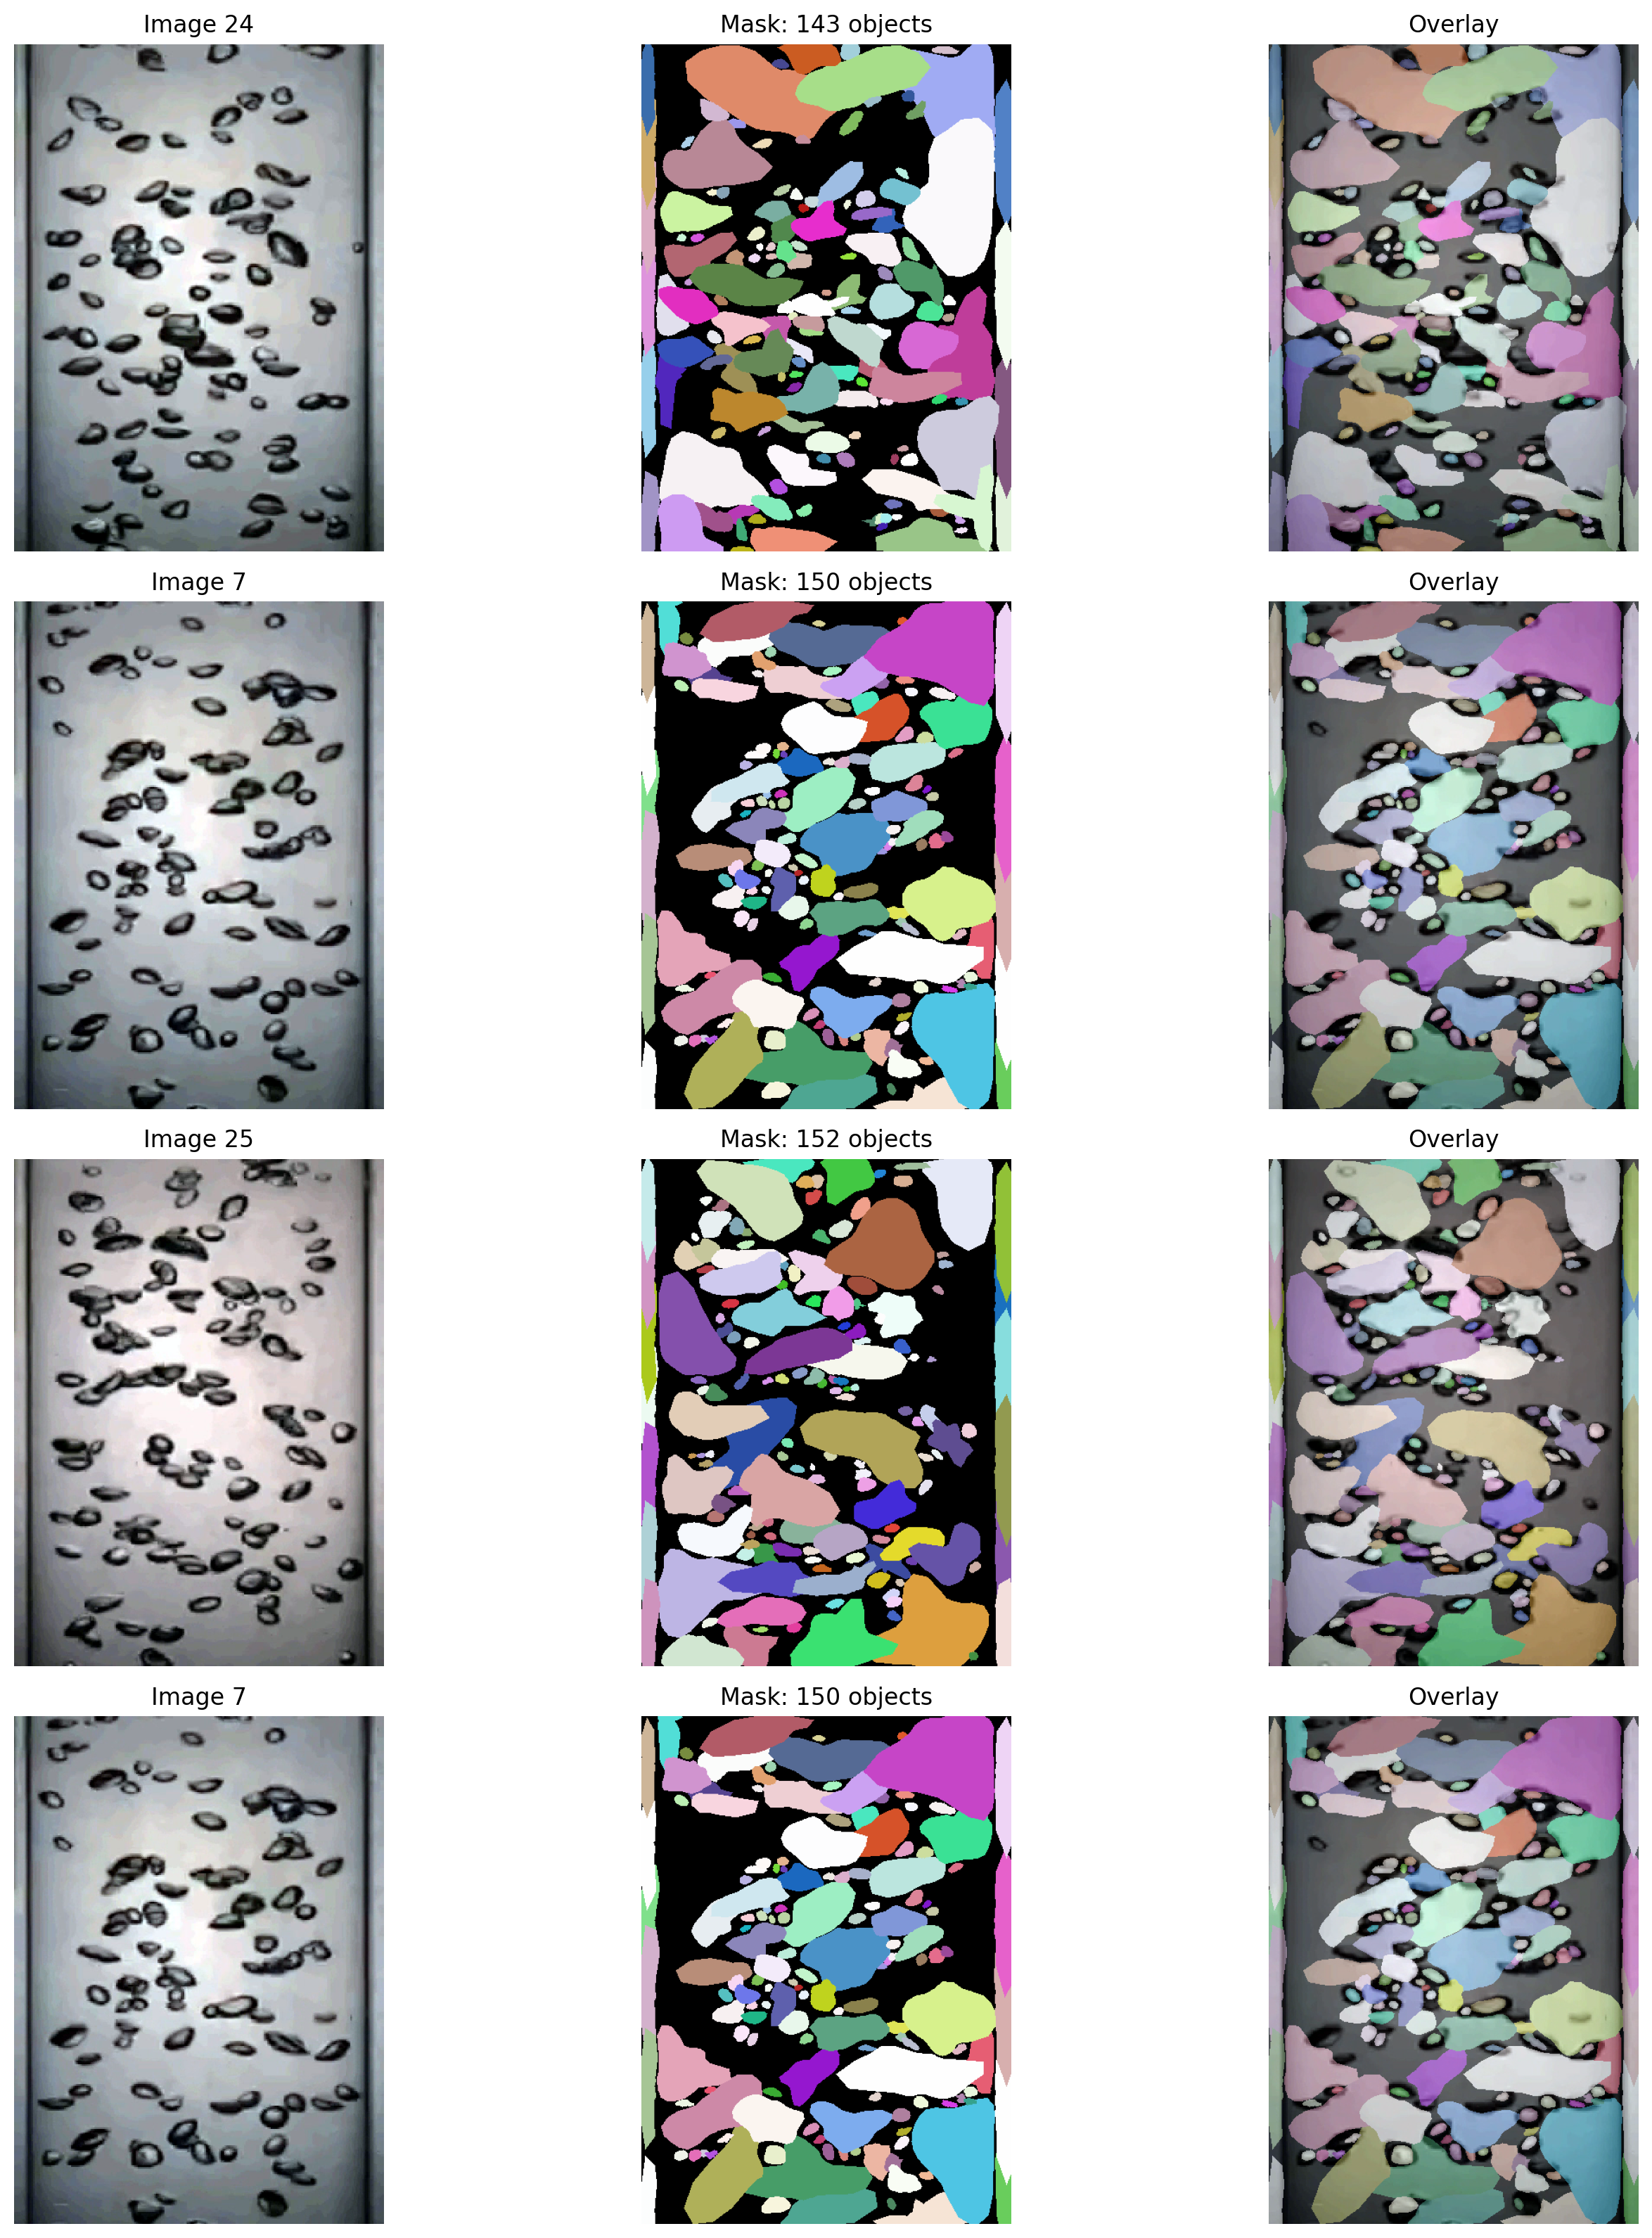


=== TRAINING SET STATISTICS ===
Number of images: 30
Total objects: 4111
Objects per image: 137.0 ± 14.2
Min/Max objects: 101 / 169


In [29]:
# Xem 4 cặp ảnh-mask ngẫu nhiên
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

for i in range(4):
    idx = np.random.randint(len(X_train))
    
    # Ảnh gốc
    img = X_train[idx]
    axes[i,0].imshow(img if img.ndim == 3 else img, cmap='gray' if img.ndim == 2 else None)
    axes[i,0].set_title(f"Image {idx}")
    axes[i,0].axis('off')
    
    # Mask
    mask = Y_train[idx]
    axes[i,1].imshow(mask, cmap=lbl_cmap)
    n_objects = len(np.unique(mask)) - 1
    axes[i,1].set_title(f"Mask: {n_objects} objects")
    axes[i,1].axis('off')
    
    # Overlay
    axes[i,2].imshow(img if img.ndim == 3 else img, cmap='gray' if img.ndim == 2 else None)
    axes[i,2].imshow(mask, cmap=lbl_cmap, alpha=0.5)
    axes[i,2].set_title("Overlay")
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()

# Thống kê
n_objects_train = [len(np.unique(y)) - 1 for y in Y_train]
print(f"\n=== TRAINING SET STATISTICS ===")
print(f"Number of images: {len(X_train)}")
print(f"Total objects: {sum(n_objects_train)}")
print(f"Objects per image: {np.mean(n_objects_train):.1f} ± {np.std(n_objects_train):.1f}")
print(f"Min/Max objects: {min(n_objects_train)} / {max(n_objects_train)}")

## 5. Tính toán kích thước objects (để chọn tham số tối ưu)

Analyzing object sizes: 100%|██████████| 30/30 [00:00<00:00, 870.61it/s]


=== OBJECT SIZE ANALYSIS ===
Median size: 20.0 pixels
Mean size: 36.4 ± 30.5 pixels
Min/Max size: 6.5 / 160.0 pixels

=== PARAMETER SUGGESTIONS ===
✅ Objects are MEDIUM sized (20-50px)
   Recommended: grid=(2,2), n_rays=32 hoặc 64


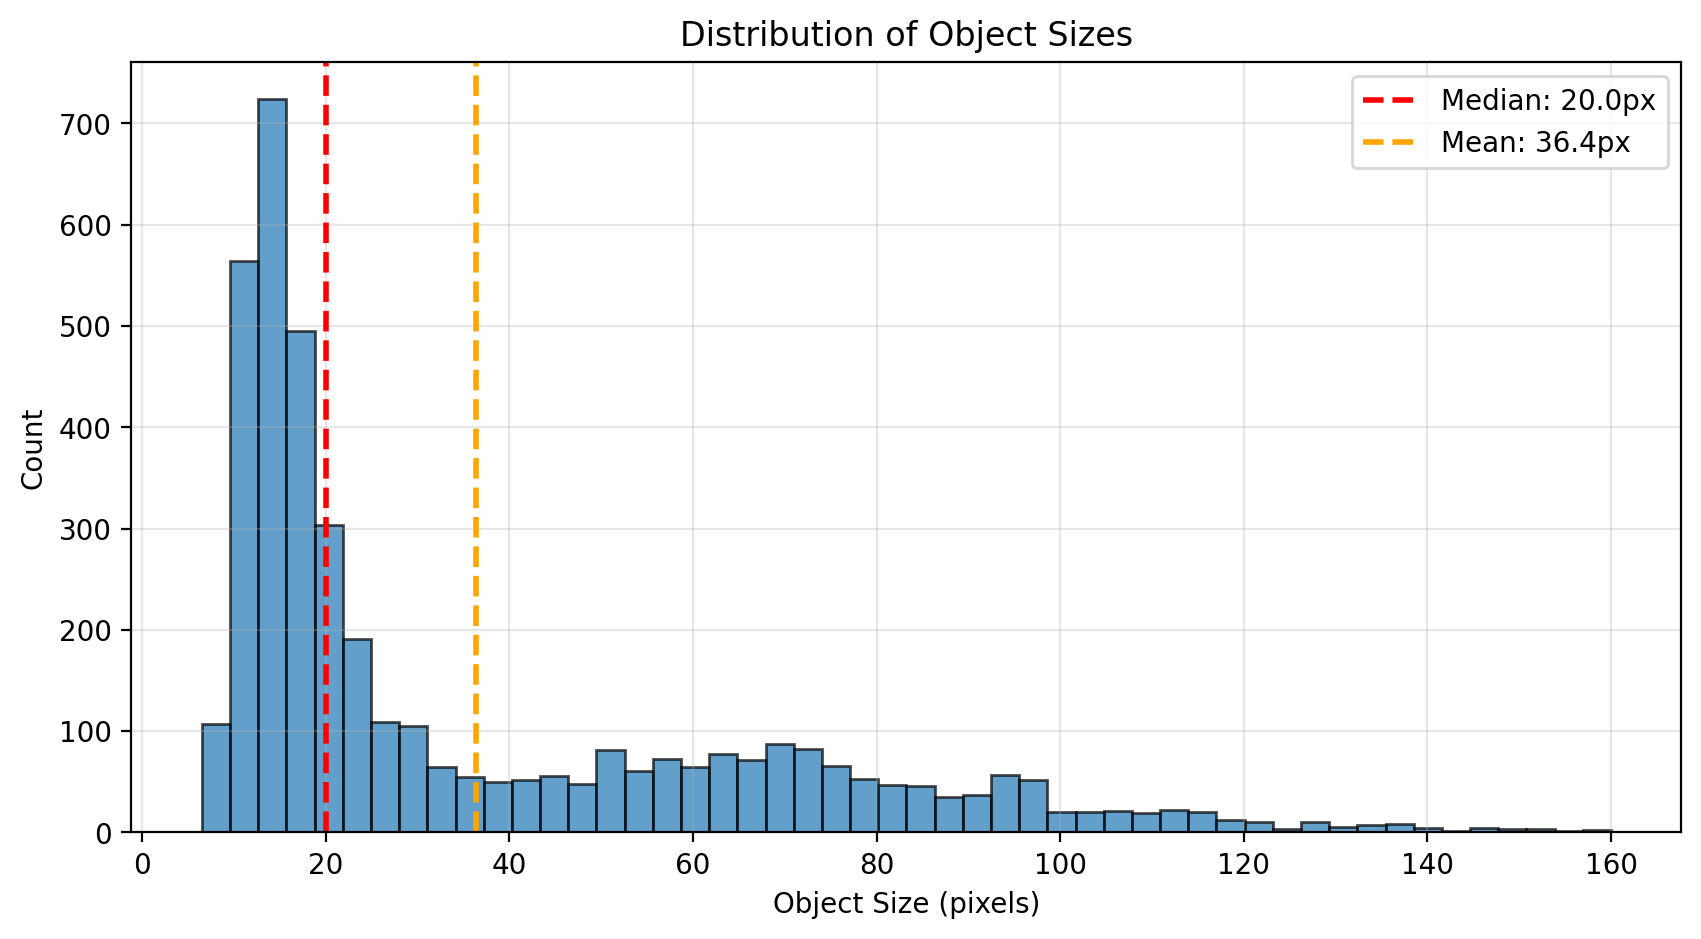

In [30]:
# Tính median object size để chọn grid size phù hợp
from scipy.ndimage import find_objects

def get_object_sizes(mask):
    """Tính kích thước của các objects trong mask"""
    sizes = []
    for obj in find_objects(mask):
        if obj is not None:
            height = obj[0].stop - obj[0].start
            width = obj[1].stop - obj[1].start
            sizes.append((height + width) / 2)
    return sizes

all_sizes = []
for y in tqdm(Y_train, desc="Analyzing object sizes"):
    all_sizes.extend(get_object_sizes(y))

median_size = np.median(all_sizes)
mean_size = np.mean(all_sizes)

print(f"\n=== OBJECT SIZE ANALYSIS ===")
print(f"Median size: {median_size:.1f} pixels")
print(f"Mean size: {mean_size:.1f} ± {np.std(all_sizes):.1f} pixels")
print(f"Min/Max size: {min(all_sizes):.1f} / {max(all_sizes):.1f} pixels")

# Gợi ý tham số dựa trên kích thước
print(f"\n=== PARAMETER SUGGESTIONS ===")
if median_size < 20:
    print(f"⚠️ Objects are SMALL (median < 20px)")
    print(f"   Recommended: grid=(1,1) hoặc (2,2), n_rays=32")
elif median_size < 50:
    print(f"✅ Objects are MEDIUM sized (20-50px)")
    print(f"   Recommended: grid=(2,2), n_rays=32 hoặc 64")
else:
    print(f"✅ Objects are LARGE (>50px)")
    print(f"   Recommended: grid=(2,2) hoặc (4,4), n_rays=64")

# Visualize phân bố
plt.figure(figsize=(10, 5))
plt.hist(all_sizes, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(median_size, color='red', linestyle='--', linewidth=2, label=f'Median: {median_size:.1f}px')
plt.axvline(mean_size, color='orange', linestyle='--', linewidth=2, label=f'Mean: {mean_size:.1f}px')
plt.xlabel('Object Size (pixels)')
plt.ylabel('Count')
plt.title('Distribution of Object Sizes')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 6. Cấu hình Model - TỐI ƯU HÓA

### Giải thích các tham số quan trọng:

- **n_rays**: Số tia để mô tả hình dạng object (32, 64, 96, 128)
  - Càng cao = mô tả hình dạng phức tạp hơn, nhưng chậm hơn
  - Objects đơn giản/tròn: 32
  - Objects phức tạp: 64-96
  
- **grid**: Downsampling factor (1, 2, 4)
  - (1,1): Chậm nhưng chính xác nhất
  - (2,2): Cân bằng tốc độ/độ chính xác (KHUYẾN NGHỊ)
  - (4,4): Nhanh nhưng kém chính xác
  
- **train_patch_size**: Kích thước patches để training
  - 256x256: Nhanh, phù hợp với objects nhỏ
  - 512x512: Chậm hơn nhưng tốt cho objects lớn
  
- **train_epochs**: Số epochs
  - Dataset nhỏ (<50 images): 200-400 epochs
  - Dataset lớn (>100 images): 100-200 epochs

In [6]:
# Cấu hình tối ưu
print("Configuring model...\n")

# THAM SỐ CHÍNH - ĐIỀU CHỈNH Ở ĐÂY
n_rays = 64          # 32: đơn giản, 64: phức tạp vừa, 96-128: rất phức tạp
grid = (2, 2)        # (1,1): chậm/chính xác, (2,2): cân bằng, (4,4): nhanh/kém
use_gpu = False      # Set to False due to gputools compatibility issues with Python 3.13
n_channel_in = n_channel

# Tính toán train_patch_size tối ưu dựa trên kích thước ảnh
img_size = X_train[0].shape[:2]
if min(img_size) < 512:
    train_patch_size = (256, 256)
else:
    train_patch_size = (512, 512)

print(f"Image size: {img_size}")
print(f"Train patch size: {train_patch_size}")

# Config
conf = Config2D(
    n_rays=n_rays,
    grid=grid,
    use_gpu=use_gpu,
    n_channel_in=n_channel_in,
    train_patch_size=train_patch_size,
    
    # Training parameters
    train_epochs=200,              # Tăng lên 300-400 nếu dataset nhỏ
    train_steps_per_epoch=100,     # Steps per epoch
    train_batch_size=4,            # Tăng nếu GPU đủ mạnh (8, 16)
    train_loss_weights=(1, 0.2),   # Weights cho distance và object probability
    
    # Learning rate
    train_learning_rate=0.0003,    # Learning rate ban đầu
    train_reduce_lr={'factor': 0.5, 'patience': 10},  # Giảm LR nếu không cải thiện
    
    # Augmentation (QUAN TRỌNG để tránh overfit!)
    train_sample_cache=True,
    train_background_reg=0.0001,
)

print("\n=== MODEL CONFIGURATION ===")
print(conf)
vars(conf)

Configuring model...

Image size: (588, 428)
Train patch size: (256, 256)

=== MODEL CONFIGURATION ===
Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=65, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=64, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=(3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, 3), net_mask_shape=(None, None, 1), train_shape_completion=False, train_completion_crop=32, train_patch_size=(256, 256), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=200, train_steps_per_epoch=100, train_learning_rate=0.0003, train_batch_size=4, train_n_val_

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 65,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 64,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 3),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 200,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


## 7. Data Augmentation (TỐI ƯU HÓA)

Augmentation giúp model tổng quát hóa tốt hơn và tránh overfit.

In [7]:
# Định nghĩa augmentation functions
def random_fliprot(img, mask, axis=None): 
    """Random flip và rotation"""
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)
    
    assert img.ndim >= mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(transpose_axis) 
    for ax in axis: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    """Random brightness và contrast"""
    img = img * np.random.uniform(0.6, 2.0)  # Brightness
    img = img + np.random.uniform(-0.2, 0.2)  # Contrast
    return img

def augmenter(x, y):
    """Main augmentation function"""
    x, y = random_fliprot(x, y, axis=(0, 1))
    x = random_intensity_change(x)
    return x, y

print("✅ Augmentation functions defined")

✅ Augmentation functions defined


## 8. Tạo và khởi tạo Model

In [8]:
# Tên model
model_name = 'stardist_my_data'
model_basedir = 'models'

# Tạo model
model = StarDist2D(conf, name=model_name, basedir=model_basedir)

print(f"\n✅ Model created: {model_name}")
print(f"   Location: {model_basedir}/{model_name}")
print(f"   Total parameters: {model.keras_model.count_params():,}")

Using default values: prob_thresh=0.5, nms_thresh=0.4.

✅ Model created: stardist_my_data
   Location: models/stardist_my_data
   Total parameters: 1,429,889


## 9. (Optional) Transfer Learning từ pre-trained model

Transfer learning có thể cải thiện đáng kể kết quả, đặc biệt với dataset nhỏ.

In [34]:
# Có muốn dùng transfer learning không?
USE_TRANSFER_LEARNING = True  # Đặt False nếu không muốn

if USE_TRANSFER_LEARNING:
    print("Loading pre-trained model for transfer learning...")
    try:
        # Thử load pre-trained model
        from stardist.models import StarDist2D
        
        # Các pre-trained models có sẵn:
        # - '2D_versatile_fluo': Tốt cho fluorescence microscopy
        # - '2D_dsb2018': Trained trên DSB 2018 dataset
        # - '2D_versatile_he': Tốt cho H&E stained images
        
        pretrained_model_name = '2D_versatile_fluo'  # Chọn model phù hợp
        pretrained = StarDist2D.from_pretrained(pretrained_model_name)
        
        # Copy weights từ pretrained model (chỉ copy những layer tương thích)
        print(f"Transferring weights from {pretrained_model_name}...")
        # Note: Chỉ transfer được nếu architecture tương tự
        # Nếu khác n_rays hoặc grid thì không transfer được
        
        print("⚠️ Note: Transfer learning chỉ hoạt động nếu n_rays và grid giống pretrained model")
        print("   Nếu gặp lỗi, đặt USE_TRANSFER_LEARNING = False")
        
    except Exception as e:
        print(f"⚠️ Could not load pretrained model: {e}")
        print("   Training from scratch...")
else:
    print("Training from scratch (no transfer learning)")

Loading pre-trained model for transfer learning...
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Transferring weights from 2D_versatile_fluo...
⚠️ Note: Transfer learning chỉ hoạt động nếu n_rays và grid giống pretrained model
   Nếu gặp lỗi, đặt USE_TRANSFER_LEARNING = False
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Transferring weights from 2D_versatile_fluo...
⚠️ Note: Transfer learning chỉ hoạt động nếu n_rays và grid giống pretrained model
   Nếu gặp lỗi, đặt USE_TRANSFER_LEARNING = False


## 10. TRAINING! 🚀

Đây là bước quan trọng nhất. Training có thể mất từ 30 phút đến vài giờ tùy vào:
- Số lượng ảnh
- Kích thước ảnh
- GPU
- Số epochs

**LƯU Ý**: Theo dõi loss curve. Nếu validation loss tăng lên → overfitting!

In [35]:
# Fix compatibility issues with Python 3.13
import subprocess
import sys
import numpy as np

print(f"Current NumPy version: {np.__version__}")
print(f"Python version: {sys.version}")

# The issue is with numpy 2.x and csbdeep compatibility
# We need to ensure numpy version is compatible
if int(np.__version__.split('.')[0]) >= 2:
    print("\n⚠️ NumPy 2.x detected. Some compatibility issues may occur.")
    print("If training fails, consider downgrading to numpy<2.0")
else:
    print("✅ NumPy version is compatible")

try:
    import gputools
    print("✅ gputools already installed")
except ImportError:
    print("\n📦 Installing gputools...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "gputools"])
    print("✅ gputools installed successfully")

Current NumPy version: 2.1.3
Python version: 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]

⚠️ NumPy 2.x detected. Some compatibility issues may occur.
If training fails, consider downgrading to numpy<2.0

📦 Installing gputools...
✅ gputools installed successfully
✅ gputools installed successfully


In [36]:
# Comprehensive patch for csbdeep compatibility with Python 3.13 + NumPy 2.x
import random
import numpy as np
import sys

# Create a patched choice function
def _patched_choice(population, k, replace=True):
    """Patched choice function compatible with NumPy 2.x and Python 3.13"""
    try:
        # save state of 'random' and set seed using 'np.random'
        state = random.getstate()
        # Use a safe range for int32 to avoid overflow
        random.seed(np.random.randint(0, 2**31 - 1))
        if replace:
            # sample with replacement
            return random.choices(population, k=k)
        else:
            # sample without replacement
            return random.sample(population, k=k)
    finally:
        # restore state of 'random'
        random.setstate(state)

# Monkey-patch at multiple levels to ensure it's applied everywhere
import csbdeep.utils.utils
csbdeep.utils.utils.choice = _patched_choice

# Also patch in sample_patches if already imported
if 'stardist.sample_patches' in sys.modules:
    import stardist.sample_patches
    stardist.sample_patches.choice = _patched_choice

print("✅ Applied comprehensive csbdeep/stardist compatibility patch")

✅ Applied comprehensive csbdeep/stardist compatibility patch


In [13]:
print("="*60)
print("STARTING TRAINING")
print("="*60)

# Training!
history = model.train(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    augmenter=augmenter,
    epochs=conf.train_epochs,
    steps_per_epoch=conf.train_steps_per_epoch,
)

print("\n" + "="*60)
print("✅ TRAINING COMPLETED!")
print("="*60)

STARTING TRAINING


ValueError: low is out of bounds for int32

In [12]:
# === RE-APPLY PATCH BEFORE TRAINING ===
import random
import numpy as np
import csbdeep.utils.utils
import stardist.sample_patches

def _safe_choice(population, k, replace=True):
    """Safe choice function for Python 3.13 + NumPy 2.x"""
    try:
        state = random.getstate()
        random.seed(np.random.randint(0, 2**30))  # Safe 32-bit range
        result = random.choices(population, k=k) if replace else random.sample(population, k=k)
        return result
    finally:
        random.setstate(state)

# Patch in BOTH locations
csbdeep.utils.utils.choice = _safe_choice
stardist.sample_patches.choice = _safe_choice

print(f"✅ Patch applied to both modules:")
print(f"   - csbdeep.utils.utils.choice = {csbdeep.utils.utils.choice.__name__}")
print(f"   - stardist.sample_patches.choice = {stardist.sample_patches.choice.__name__}")

✅ Patch applied to both modules:
   - csbdeep.utils.utils.choice = _safe_choice
   - stardist.sample_patches.choice = _safe_choice


## 11. Visualize Training History

In [ ]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Loss
ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14)
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Zoom vào cuối
start_epoch = len(history.history['loss']) // 4
ax2.plot(history.history['loss'][start_epoch:], label='Training Loss', linewidth=2)
ax2.plot(history.history['val_loss'][start_epoch:], label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title(f'Loss (Last {len(history.history["loss"]) - start_epoch} Epochs)', fontsize=14)
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f'{model_basedir}/{model_name}/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

# Tìm epoch tốt nhất
best_epoch = np.argmin(history.history['val_loss']) + 1
best_val_loss = min(history.history['val_loss'])
print(f"\n=== TRAINING SUMMARY ===")
print(f"Best epoch: {best_epoch}/{len(history.history['val_loss'])}")
print(f"Best validation loss: {best_val_loss:.4f}")

# Cảnh báo nếu overfit
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
if final_val_loss > final_train_loss * 1.5:
    print("\n⚠️ WARNING: Model might be OVERFITTING!")
    print("   Suggestions:")
    print("   - Thêm data augmentation")
    print("   - Giảm số epochs")
    print("   - Thêm dữ liệu training")
elif final_val_loss > final_train_loss * 0.5:
    print("\n✅ Training looks good!")
else:
    print("\n⚠️ Model might be UNDERFITTING")
    print("   Suggestions:")
    print("   - Tăng số epochs")
    print("   - Tăng model complexity (n_rays)")
    print("   - Giảm regularization")

## 12. Tối ưu hóa thresholds trên validation set

In [ ]:
print("Optimizing detection thresholds on validation set...\n")

# Tối ưu thresholds
model.optimize_thresholds(
    X_val, Y_val,
    nms_threshs=[0.3, 0.4, 0.5],  # NMS thresholds để thử
    iou_threshs=[0.3, 0.4, 0.5],  # IoU thresholds để đánh giá
)

print("\n✅ Thresholds optimized!")
print(f"   Optimal NMS threshold: {model.thresholds.nms:.3f}")
print(f"   Optimal probability threshold: {model.thresholds.prob:.3f}")

## 13. Evaluate trên Validation Set

In [ ]:
from stardist.matching import matching_dataset

print("Evaluating on validation set...\n")

# Predict trên validation set
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0] 
              for x in tqdm(X_val, desc="Predicting")]

# Calculate metrics
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) 
         for t in tqdm([0.5, 0.6, 0.7, 0.8, 0.9], desc="Computing metrics")]

# Print results
print("\n" + "="*60)
print("VALIDATION RESULTS")
print("="*60)
print("\nAverage Precision (AP) at different IoU thresholds:")
for (thr, stat) in zip([0.5, 0.6, 0.7, 0.8, 0.9], stats):
    print(f"  IoU {thr:.1f}: AP = {stat.mean_matched_score:.3f}, "
          f"Recall = {stat.mean_true_score:.3f}, "
          f"Precision = {stat.mean_matched_score:.3f}")

# Overall score
ap_50 = stats[0].mean_matched_score
print(f"\n{'='*60}")
print(f"🎯 OVERALL SCORE (AP@0.5): {ap_50:.3f}")
print(f"{'='*60}")

if ap_50 > 0.8:
    print("\n🎉 EXCELLENT! Model performance is very good!")
elif ap_50 > 0.7:
    print("\n✅ VERY GOOD! Model performance is good.")
elif ap_50 > 0.6:
    print("\n👍 GOOD! Model performance is acceptable.")
else:
    print("\n⚠️ Model performance is moderate. Consider:")
    print("   - Kiểm tra lại annotations")
    print("   - Thêm dữ liệu training")
    print("   - Tăng n_rays hoặc giảm grid")
    print("   - Training thêm epochs")

## 14. Visualize Predictions

In [ ]:
# Xem predictions trên một số ảnh validation
n_samples = min(6, len(X_val))
sample_indices = np.random.choice(len(X_val), n_samples, replace=False)

fig, axes = plt.subplots(n_samples, 4, figsize=(16, 4*n_samples))
if n_samples == 1:
    axes = axes.reshape(1, -1)

for i, idx in enumerate(sample_indices):
    img = X_val[idx]
    mask_true = Y_val[idx]
    mask_pred = Y_val_pred[idx]
    
    # Original image
    axes[i, 0].imshow(img if img.ndim == 3 else img, cmap='gray' if img.ndim == 2 else None)
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')
    
    # Ground truth
    axes[i, 1].imshow(mask_true, cmap=lbl_cmap)
    n_true = len(np.unique(mask_true)) - 1
    axes[i, 1].set_title(f"Ground Truth ({n_true} objects)")
    axes[i, 1].axis('off')
    
    # Prediction
    axes[i, 2].imshow(mask_pred, cmap=lbl_cmap)
    n_pred = len(np.unique(mask_pred)) - 1
    axes[i, 2].set_title(f"Prediction ({n_pred} objects)")
    axes[i, 2].axis('off')
    
    # Overlay
    axes[i, 3].imshow(img if img.ndim == 3 else img, cmap='gray' if img.ndim == 2 else None)
    axes[i, 3].imshow(mask_pred, cmap=lbl_cmap, alpha=0.5)
    axes[i, 3].set_title("Overlay")
    axes[i, 3].axis('off')

plt.tight_layout()
plt.savefig(f'{model_basedir}/{model_name}/validation_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

## 15. Export Model

Model đã được tự động lưu trong quá trình training. Bạn có thể load lại bằng:

In [ ]:
print(f"\n{'='*60}")
print("MODEL SAVED")
print(f"{'='*60}")
print(f"\nLocation: {model_basedir}/{model_name}")
print(f"\nĐể load lại model:")
print(f"```python")
print(f"from stardist.models import StarDist2D")
print(f"model = StarDist2D(None, name='{model_name}', basedir='{model_basedir}')")
print(f"```")
print(f"\n✅ Training hoàn tất! Bây giờ bạn có thể:")
print(f"   1. Chạy notebook 2_prediction_my_data.ipynb để predict trên toàn bộ 886 frames")
print(f"   2. Nếu kết quả chưa tốt, quay lại điều chỉnh tham số hoặc thêm dữ liệu")
print(f"   3. Export sang các format khác (ImageJ, QuPath, etc.)")

---
## 📊 CHECKLIST ĐÁNH GIÁ KẾT QUẢ

### ✅ Model tốt nếu:
- [ ] AP@0.5 > 0.6 (tốt), > 0.7 (rất tốt), > 0.8 (xuất sắc)
- [ ] Validation loss không tăng trong 20 epochs cuối
- [ ] Predictions trên validation set trông hợp lý
- [ ] Số objects detected gần với ground truth

### ⚠️ Cần cải thiện nếu:
- [ ] AP@0.5 < 0.6
- [ ] Validation loss tăng → Overfitting
- [ ] Quá nhiều false positives → Tăng prob_thresh
- [ ] Quá nhiều false negatives → Giảm prob_thresh
- [ ] Không tách được objects chồng lấp → Tăng n_rays

### 🔄 Các bước cải thiện:
1. **Nếu overfit**: Thêm augmentation, giảm epochs, thêm dữ liệu
2. **Nếu underfit**: Tăng n_rays, tăng epochs, giảm grid
3. **Nếu kết quả kém**: Kiểm tra lại annotations, thêm dữ liệu khó
4. **Iterative improvement**: Train → Evaluate → Fix annotations → Retrain